# Random Forest Hyper-parameter search, Target: wflow_sbm streamflow

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.base import clone 

from scipy.stats import ks_2samp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from functools import partial
from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt
from pathlib import Path

## Set Paths

In [2]:
# Set paths
ROOT = Path('/gpfs/work1/0/wtrcycle/users/jaerts/model_refinement_pub/')
RESULTS = f'{ROOT}/results/new/'

## Load data

In [3]:
# Load Dataframe
df_wflow = pd.read_csv(f'{RESULTS}/rf_feature_selection/rf_wflow_pcrglob_streamflow_camels_attrs.csv', index_col='basin_id')

# Change to -0.42
df_wflow.loc[df_wflow['kge_np_wflow'] < -0.42, 'kge_np_wflow'] = -0.42
df_wflow = df_wflow.dropna()
len(df_wflow)

636

## Define folds

In [4]:
def create_folds(df, variable, n_s=10, n_grp=10):
    df = df.reset_index()
    df['Fold'] = -1
    skf = StratifiedKFold(n_splits=n_s, shuffle=True, random_state=1)
    df['grp'] = pd.cut(df[variable], n_grp, labels=False)
    target = df.grp
    for fold_no, (t, v) in enumerate(skf.split(target, target)):
        df.loc[v, 'Fold'] = fold_no
    return df

In [5]:
# create folds
n_groups = 25
n_folds = 10

df = create_folds(df_wflow, variable='kge_np_wflow', n_s=n_folds, n_grp=n_groups)

/home/jaerts/miniconda3/envs/wflow_state_flux/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


## Test folds

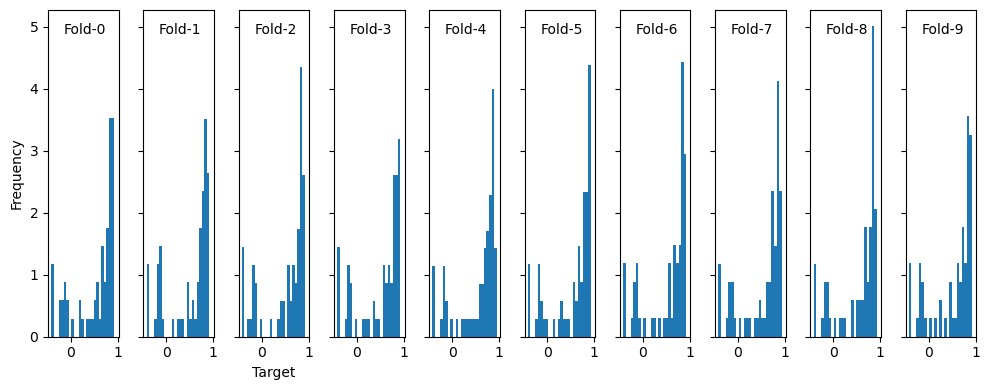

Fold 0 vs 1: KstestResult(statistic=0.078125, pvalue=0.9907746509475145)
Fold 0 vs 2: KstestResult(statistic=0.078125, pvalue=0.9907746509475145)
Fold 0 vs 3: KstestResult(statistic=0.09375, pvalue=0.9439990378651473)
Fold 0 vs 4: KstestResult(statistic=0.09375, pvalue=0.9439990378651473)
Fold 0 vs 5: KstestResult(statistic=0.109375, pvalue=0.842628651159718)
Fold 0 vs 6: KstestResult(statistic=0.08432539682539683, pvalue=0.9562247667328524)
Fold 0 vs 7: KstestResult(statistic=0.07142857142857142, pvalue=0.9899954941367332)
Fold 0 vs 8: KstestResult(statistic=0.06845238095238096, pvalue=0.9942361862476986)
Fold 0 vs 9: KstestResult(statistic=0.06671626984126984, pvalue=0.9958834125810943)


In [6]:
fig, axs = plt.subplots(1, 10, sharex=True, sharey=True, figsize=(10,4))
for i, ax in enumerate(axs):
    ax.hist(df[df.Fold == i]['kge_np_wflow'], bins=n_groups, density=True, label=f'Fold-{i}')
    if i == 0:
        ax.set_ylabel('Frequency')
    if i == 2:
        ax.set_xlabel("Target")
    ax.legend(frameon=False, handlelength=0)
plt.tight_layout()
plt.show()

for fold in np.sort(df.Fold.unique())[1:]:
    print(f'Fold 0 vs {fold}:', ks_2samp(df.loc[df.Fold==0,'kge_np_wflow'], df.loc[df.Fold==fold,'kge_np_wflow']))

## Define target and features

In [7]:
X = df.drop(columns=['basin_id', 'kge_np_wflow','kge_np_pcrglob'])
y = df['kge_np_wflow']

In [8]:
len(X.columns)

60

# Hyper parameter search

## Set Search Space TPE and config

In [9]:
search_space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 10),
    'max_depth': hp.quniform('max_depth', 1, 10, 1),
    'max_features': hp.quniform('max_features', 0.1, 1, 0.1),
    'max_samples': hp.quniform('max_samples', 0.1, 1, 0.1), 
    'random_state': hp.quniform('random_state', 1, 500, 100)
}

search_space = {
    'n_estimators': hp.quniform('n_estimators', 10, 800, 10),
    'max_depth': hp.quniform('max_depth', 1, 15, 1),
    'max_features': hp.quniform('max_features', 0.1, 1, 0.1),
    'max_samples': hp.quniform('max_samples', 0.1, 1, 0.1), 
    'random_state': hp.quniform('random_state', 1, 500, 100)
}



# Set Iterations TPE
evals = 300

# Create Output Dict
trials = Trials()

## TPE Functions

In [10]:
def train_score_rf(params, n_folds=n_folds, X=X, y=y):
    # Loop folds, leave 1 out
    losses = []
    for k in range(n_folds):
        X_test = X.loc[X.Fold==k]
        X_test = X_test.drop(columns=['Fold','grp'])
        y_test = y.loc[X_test.index]

        X_train = X.drop(X_test.index)
        X_train = X_train.drop(columns=['Fold','grp'])
        y_train = y.loc[X_train.index]

        # Standardize data
        # https://towardsdatascience.com/how-data-normalization-affects-your-random-forest-algorithm-fbc6753b4ddf
        scaler = StandardScaler()
        
        X_train_scale = scaler.fit_transform(X_train)
        X_test_scale = scaler.transform(X_test)      
        y_train_scale = scaler.fit_transform(y_train.values.reshape(-1,1)).ravel()
        y_test_scale = scaler.transform(y_test.values.reshape(-1,1)).ravel()
        
        # Define random forest model
        rf = RandomForestRegressor(
            n_estimators=int(params['n_estimators']),
            max_depth=int(params['max_depth']),
            max_features=float(params['max_features']),
            max_samples=float(params['max_samples']),
            # min_samples_split=int(params['min_samples_split']),
            # min_samples_leaf=int(params['min_samples_leaf']),
            random_state=int(params['random_state'])
        ).fit(X_train_scale , y_train_scale)     
        
        # Loss function is Mean squared error
        loss = np.mean((rf.predict(X_test_scale) - y_test_scale)**2) #Mean squared error
        losses.append(loss)
    
    return {'loss': np.mean(losses), 'status': STATUS_OK}

def read_val_from_trials(val):
        """Helps reading trials"""
        try:
            return val[0]
        except:
            return 0
        
def trials_to_df(trials):
    """Convert complex trials dictionary to dataframe"""
    df = pd.DataFrame(index = range(len(trials.trials)), columns = trials.trials[0]['misc']['vals'].keys())
    df.loc[:, :] = [[read_val_from_trials(trials.trials[i]['misc']['vals'][k]) for k in trials.trials[i]['misc']['vals'].keys()] for i in range(len(trials.trials))]
    df.loc[:, 'loss'] = [trials.trials[i]['result']['loss'] for i in range(len(trials.trials))]

    return df

## Calculate hyper-parameters

In [11]:
iteration=0
# Define progress bar
pbar=trange(iteration, evals, initial=iteration, total=evals)


for t in pbar:
    best = fmin(
        fn=train_score_rf,
        space=search_space,
        max_evals=iteration+1,
        algo=partial(tpe.suggest, n_startup_jobs=25),
        trials=trials,
        verbose=0
    )
    
    trials_df = trials_to_df(trials)
    best_loss = trials_df.loss.min()
    
    iteration+=1
    print(np.round(best_loss, decimals=2), end='\r')
    pbar.set_postfix({'Lowest loss': np.round(best_loss, decimals=2)})

  0%|          | 0/300 [00:00<?, ?it/s]

## Store output

In [12]:
# Save output to file
trials_df.to_csv(f'{RESULTS}/rf_feature_selection/hyper_parameters/rf_hyperparam_wflow_streamflow.csv')
trials_df.sort_values('loss').iloc[0]

max_depth            9.0
max_features         0.4
max_samples          1.0
n_estimators       230.0
random_state       500.0
loss            0.418103
Name: 140, dtype: object